In [1]:
from indra_cogex.sources.odinson.grammars import Rule
from indra_cogex.sources.odinson.client import process_rules
import gilda
import pandas as pd
from collections import defaultdict
from gilda.process import normalize
from tqdm.auto import tqdm
from pyobo.gilda_utils import get_gilda_terms

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#reformat terms
df = pd.read_csv('spine.tsv', sep = '\t', header = None, names = ['name', 'id'])
#for each id, make a list of the corresponding brain regions
id_to_names = defaultdict(list)
for name,identifier in df.values:
    id_to_names[identifier].append(name)
terms = []
#label terms with the same id as synonyms
for identifier, names in id_to_names.items():
    #label everything except the first as synonyms
    name,*synonyms = names
    term = gilda.term.Term(
                norm_text=normalize(name),
                text=name,
                db="spine",
                id=identifier,
                entry_name=name,
                status="name",
                source="spine",
            )
    terms.append(term)
    for synonym in synonyms:
        term = gilda.term.Term(
                norm_text=normalize(synonym),
                text=synonym,
                db="spine",
                id=identifier,
                entry_name=name,
                status="synonym",
                source="spine",
            )
        terms.append(term)
terms.extend(get_gilda_terms('UBERON'))
terms.extend(get_gilda_terms('fma'))
#terms.extend(get_gilda_terms('ncit'))
grounder = gilda.Grounder(terms)
grounder

[UBERON] mapping: 100%|██████████████████| 14.5k/14.5k [00:00<00:00, 255kname/s]
[UBERON] mapping: 100%|██████████████| 9.84k/9.84k [00:00<00:00, 71.3ksynonym/s]
[fma] mapping: 100%|█████████████████████| 79.0k/79.0k [00:00<00:00, 248kname/s]
[fma] mapping: 100%|█████████████████| 29.8k/29.8k [00:00<00:00, 87.5ksynonym/s]


In [3]:
#list of rules with two named entities
binary_rules = ["(?<connector> [entity=B-TissueType][entity=I-TissueType]*) <nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType][entity=I-TissueType]*) and ([entity=B-TissueType][entity=I-TissueType]*)",
               "(?<connector> [entity=B-TissueType][entity=I-TissueType]*) <nsubj [lemma=connect]>dobj ([entity=B-TissueType][entity=I-TissueType]*) and (?<region> [entity=B-TissueType][entity=I-TissueType]*)",
               "([entity=B-TissueType][entity=I-TissueType]*) <nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType][entity=I-TissueType]*) and (?<region> [entity=B-TissueType][entity=I-TissueType]*)",
               "(?<connector> [entity=B-TissueType][entity=I-TissueType]*)<nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType][entity=I-TissueType]*)",
               "([tag=/N.*/]) <nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType][entity=I-TissueType]*) (?<region> [entity=B-TissueType][entity=I-TissueType]*)",
               "([tag=/N.*/]) <nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType][entity=I-TissueType]*) and (?<region> [entity=B-TissueType][entity=I-TissueType]*)",
               "[tag=/N.*/]) <nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType][entity=I-TissueType]*) with (?<region> [entity=B-TissueType][entity=I-TissueType]*)",
               "(?<connector> [entity=B-TissueType][entity=I-TissueType]*)<nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType])"]

#regionconnect=Rule("anatomical connection", "Exp", "basic", "(?<connector> [entity=B-TissueType][entity=I-TissueType]*)[lemma=connect]")

In [9]:
#get the start and end numbers
relations = []
for rule_text in tqdm(binary_rules):
    rule = Rule("anatomical connection", "Exp", "basic", rule_text)
    try:
        rule_output = process_rules([rule],"http://localhost:9000")
    except Exception as e:
        print('failed', rule)
        print(e)
        continue
    for sentence in rule_output['mentions']:
        relation = ()
        words = sentence['words']
        for element in sentence['match']:  
            for entity in element['namedCaptures']:
                start = entity['capturedMatch']['start']
                end = entity['capturedMatch']['end']
                word = ' '.join(words[start:end])
                spine_scored_match = grounder.ground(word)
                gilda_scored_match = gilda.ground(word)
                if len(gilda_scored_match)>0:
                    best_curie = gilda_scored_match[0].term.get_curie()
                elif len(spine_scored_match)>0:
                    best_curie = spine_scored_match[0].term.get_curie()
                else:
                    best_curie = None
                relation += ((best_curie, word),)  
        relations.append(relation)
        print(words, relations)

            
            

 38%|████████████████▉                            | 3/8 [00:00<00:00,  8.81it/s]

failed Rule(anatomical connection, Exp, basic, (?<connector> [entity=B-TissueType][entity=I-TissueType]*) <nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType][entity=I-TissueType]*) and ([entity=B-TissueType][entity=I-TissueType]*)) 400 Client Error: Bad Request for url: http://localhost:9000/api/execute/grammar
success Rule(anatomical connection, Exp, basic, (?<connector> [entity=B-TissueType][entity=I-TissueType]*) <nsubj [lemma=connect]>dobj ([entity=B-TissueType][entity=I-TissueType]*) and (?<region> [entity=B-TissueType][entity=I-TissueType]*))
success Rule(anatomical connection, Exp, basic, ([entity=B-TissueType][entity=I-TissueType]*) <nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType][entity=I-TissueType]*) and (?<region> [entity=B-TissueType][entity=I-TissueType]*))
success Rule(anatomical connection, Exp, basic, (?<connector> [entity=B-TissueType][entity=I-TissueType]*)<nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType][entity=I-TissueType]*))
['Forn

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 13.44it/s]

success Rule(anatomical connection, Exp, basic, ([tag=/N.*/]) <nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType][entity=I-TissueType]*) (?<region> [entity=B-TissueType][entity=I-TissueType]*))
success Rule(anatomical connection, Exp, basic, ([tag=/N.*/]) <nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType][entity=I-TissueType]*) and (?<region> [entity=B-TissueType][entity=I-TissueType]*))
failed Rule(anatomical connection, Exp, basic, [tag=/N.*/]) <nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType][entity=I-TissueType]*) with (?<region> [entity=B-TissueType][entity=I-TissueType]*)) 400 Client Error: Bad Request for url: http://localhost:9000/api/execute/grammar
success Rule(anatomical connection, Exp, basic, (?<connector> [entity=B-TissueType][entity=I-TissueType]*)<nsubj [lemma=connect]>dobj (?<region> [entity=B-TissueType]))
['Fornix', '(', 'FX', ')', ':', 'The', 'fornix', 'connects', 'the', 'hippocampus', 'with', 'the', 'mammillary', 'bodies', ',', 'the', 

In [10]:
relations

[(('spine:67e38c9d-d78f-42b8-b83d-a2f6e86e3261', 'fornix'),
  ('mesh:D006624', 'hippocampus')),
 (('spine:67e38c9d-d78f-42b8-b83d-a2f6e86e3261', 'fornix'),
  ('mesh:D006624', 'hippocampus'))]

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/97/57/00afb5440455c058c0ecc81c49f90113419e18cfdc42b2ed0d6c0ba35bf0/matplotlib-3.8.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/5b/ac/26fa1057f62beaa2af4c55c6ac733b114a403b746cfe0ce3dc6e4aec921a/contourpy-1.2.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/0e/50/cdebef90cb54b3ecae8155daf9799f610e21735d13ddd38ac379b48661dc/fonttools-4.44.1-cp311-cp311-macosx_10_9_universal2.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 5.1 MB/s eta 0:00:00
  Obtaining dependency informati

INFO: [2023-11-14 13:00:50] matplotlib.font_manager - Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
INFO: [2023-11-14 13:00:51] matplotlib.font_manager - Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
INFO: [2023-11-14 13:00:51] matplotlib.font_manager - Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
INFO: [2023-11-14 13:00:51] matplotlib.font_manager - generated new fontManager


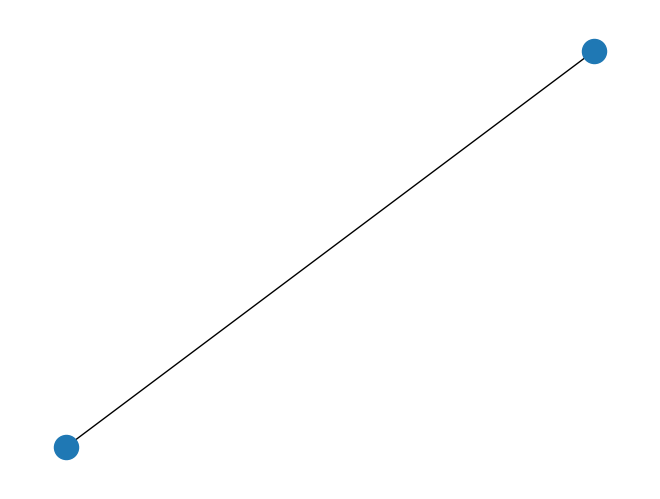

In [13]:
#figure out how to add names to nodes, use graphvis to output graph, get it to a point of more relationships, rules w uberon/fma
!pip install matplotlib
import networkx as nx
G = nx.Graph()
G.add_edges_from(relations)
nx.draw(G)

In [5]:
scoredmatches = gilda.ground('ER')
scoredmatches[0].term.get_curie()

'fplx:ESR'

In [6]:
benchmark_url = ('https://docs.google.com/spreadsheets/d/e/2PACX-1vS6uvih2Hi7dIo9Nabk5gv2kz67avmHpiWvqtNOKxrr43WhxSCBwzyq'
'lLvi841Vx3f1LoF7GF_5Cff3/pub?output=tsv')
benchmark_df = pd.read_csv(benchmark_url, sep='\t')
subject = gilda.ground_df(benchmark_df, 'subject', grounder=grounder)
object = gilda.ground_df(benchmark_df, 'object', grounder=grounder)

benchmark_df


,sentence,subject,subject_curie,predicate,object,object_curie,subject_grounded,object_grounded
0,Although traditionally viewed as a primary mot...,corticospinal neurons,NaN,innervate,spinal dorsal horn,NaN,None,None
1,The prefrontal cortices are connected by the f...,prefrontal cortices,NaN,connected by,fibers of the genu,NaN,None,None
2,The stria terminalis (ST) provides afferent an...,stria terminalis,uberon:0003029,provides,septal nuclei,uberon:0002663,uberon:0003029,uberon:0002663
3,The sensorimotor strip follows a medial-poster...,sensorimotor strip,NaN,follows a course from,apex,NaN,None,None
4,PMC does not encompass the entire thickness of...,PMC,NaN,occupies,posterior margin of precentral gyrus,NaN,None,None
5,PMC does not encompass the entire thickness of...,PMC,NaN,occupies,anterior bank of central sulcus,NaN,None,None
6,PMC does not encompass the entire thickness of...,PMC,NaN,occupies,anterior part of paracentral lobule,uberon:0035932,None,uberon:0035932
7,The rostrum contains connections to the orbita...,rostrum,uberon:7500071,contains connections to,orbital frontal cortex,uberon:0004167,uberon:7500071,uberon:0004167
8,The rostrum contains connections to the orbita...,rostrum,uberon:7500071,contains connections to,frontal pole,uberon:0002795,uberon:7500071,uberon:0002795
9,The commissural fibers passing through the gen...,commissural fibers,NaN,passing through,genu,uberon:0015599,None,uberon:0015599
